Attempt at concatenating netcdf subdomain files.

In [1]:
import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

Strategy: For each variable on the horizontal grid, insert the data from each subdomain into the correct position of a larger array. Also, copy all of the other  

First, I need to determine how the subdomains are organized. The subdomains are divided into rows and columns. An example decomposition is:

|  |  |  |  |
|--|--|--|--|
|08|09|10|11|
|04|05|06|07|
|00|01|02|03|


For my case, I have figured this layout out "by eye" and stored in an array called filenames. Ideally, we would write code to determine the decomposition automatically. This is complicated by the fact that we do not always wish to recombine over the full domain.

Next, I can determine the x/y start and end indces for each of my sudomains by knowing the dimensions of each subdomain. I will store these in a dictionary with a filename key.

Next, I will initialize the dimensions and variables of my new file by copying the dimensions and variables of the file in filenames[0,0]. 

Finally, I will loop through each file and each variable and insert the data into the correct positition of my new array. I have written some functions to help with this. 

In [4]:
def define_shapes(filenames):
    """Creates a dictionary object that stores the beginning and ending i, j coordinate for each 
    subdomain file stored in names.
    Names should be orgnaized in a way that corresponds to the shape of the region you are compiling.
    The first axis (rows) of names is along y, second axis (columns) is along x
    names[0,0] is the bottom left subdomain
    names[-1,0] is the top left subdomain
    names[0,-1] is the bottom right subdomain
    names[-1,-1] is the top right subdomain
    
    Beginning/ending i = iss/iee, beginning/ending j = jss/jee
    
    returns: a dictionary of dictionarys. First level keys are the filenames, second level are iss,iee,jss,jee
    """
    
    jss = 0
    for j in np.arange(filenames.shape[0]):
        iss = 0
        for i in np.arange(filenames.shape[1]):
            name = filenames[j,i]
            f = nc.Dataset(name)
            x = f.dimensions['x'].__len__()
            y = f.dimensions['y'].__len__()
            shapes[name] = {}
            shapes[name]['iss'] = iss
            shapes[name]['iee'] = iss+x
            shapes[name]['jss'] = jss
            shapes[name]['jee'] = jss+y
            iss = iss+x
        jss = jss +y
    return shapes

Check that it works for my case.

In [5]:
shapes = {}
filenames = np.array([['CODAR_0139.nc', 'CODAR_0140.nc', 'CODAR_0141.nc'],
         ['CODAR_0151.nc', 'CODAR_0152.nc', 'CODAR_0153.nc'],
         ['CODAR_0163.nc', 'CODAR_0164.nc', 'CODAR_0165.nc']])


shapes = define_shapes(filenames)

In [6]:
shapes

{'CODAR_0139.nc': {'iee': 25, 'iss': 0, 'jee': 22, 'jss': 0},
 'CODAR_0140.nc': {'iee': 58, 'iss': 25, 'jee': 22, 'jss': 0},
 'CODAR_0141.nc': {'iee': 80, 'iss': 58, 'jee': 22, 'jss': 0},
 'CODAR_0151.nc': {'iee': 25, 'iss': 0, 'jee': 55, 'jss': 22},
 'CODAR_0152.nc': {'iee': 58, 'iss': 25, 'jee': 55, 'jss': 22},
 'CODAR_0153.nc': {'iee': 80, 'iss': 58, 'jee': 55, 'jss': 22},
 'CODAR_0163.nc': {'iee': 25, 'iss': 0, 'jee': 80, 'jss': 55},
 'CODAR_0164.nc': {'iee': 58, 'iss': 25, 'jee': 80, 'jss': 55},
 'CODAR_0165.nc': {'iee': 80, 'iss': 58, 'jee': 80, 'jss': 55}}

Create a new netcdf file. 

In [7]:
new = nc.Dataset('CODAR_all.nc', 'w')

Iniitilize dimensions

In [8]:
def initialize_dimensions(newfile, oldfile):
    """Initialize new file to have the same dimension names as oldfile
    Dimensions that are not associated with the horizontal grid are also given
    the same size as oldfile"
    """
    for dimname in oldfile.dimensions:
        dim = oldfile.dimensions[dimname]
        if dimname=='x' or dimname=='y':
            newdim = newfile.createDimension(dimname) 
        else:   
            newdim = newfile.createDimension(dimname, size=dim.__len__())

In [9]:
initialize_dimensions(new, nc.Dataset(filenames[0,0]))

Check

In [10]:
print(new.dimensions)

OrderedDict([('x', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'x', size = 0
), ('y', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'y', size = 0
), ('deptht', <class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40
), ('depthu', <class 'netCDF4._netCDF4.Dimension'>: name = 'depthu', size = 40
), ('depthv', <class 'netCDF4._netCDF4.Dimension'>: name = 'depthv', size = 40
), ('time_counter', <class 'netCDF4._netCDF4.Dimension'>: name = 'time_counter', size = 960
), ('tbnds', <class 'netCDF4._netCDF4.Dimension'>: name = 'tbnds', size = 2
)])


Initialize variables

In [11]:
def initialize_variables(newfile, oldfile):
    """Initialize new file to have the same variables as oldfile
    """
    newvars = {}
    for varname in oldfile.variables:
        var = oldfile.variables[varname]
        dims = var.dimensions
        newvar = newfile.createVariable(varname, 'float32', dims)
        newvar[:]=var[:]
        newvars[varname] = newvar
    return newvars

In [13]:
newvars=initialize_variables(new, nc.Dataset(filenames[0,0]))

In [14]:
new.dimensions

OrderedDict([('x',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'x', size = 25),
             ('y',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'y', size = 22),
             ('deptht',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40),
             ('depthu',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'depthu', size = 40),
             ('depthv',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'depthv', size = 40),
             ('time_counter',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'time_counter', size = 960),
             ('tbnds',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'tbnds', size = 2)])

In [15]:
new.variables

OrderedDict([('nav_lon', <class 'netCDF4._netCDF4.Variable'>
              float32 nav_lon(y, x)
              unlimited dimensions: y, x
              current shape = (22, 25)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('nav_lat', <class 'netCDF4._netCDF4.Variable'>
              float32 nav_lat(y, x)
              unlimited dimensions: y, x
              current shape = (22, 25)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('deptht', <class 'netCDF4._netCDF4.Variable'>
              float32 deptht(deptht)
              unlimited dimensions: 
              current shape = (40,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('depthu', <class 'netCDF4._netCDF4.Variable'>
              float32 depthu(depthu)
              unlimited dimensions: 
              current shape = (40,)
              filling on, default _FillValue of 9.969209968386869e+36 used)

Add new data from all files

In [16]:
def concatentate_variables(filenames, shapes, variables):
    """Concatentate netcdf variables listed in dictionary variables for all of the
    files stored in filenames. shapes is a dictionary object that stores the start and 
    end index for the subdomain in each file. """
    for name in filenames.flatten():
        for varname in variables.keys():
            newvar = newvars[varname]
            f = nc.Dataset(name)
            oldvar = f.variables[varname]
            x1=shapes[name]['iss']
            x2=shapes[name]['iee']
            y1=shapes[name]['jss']
            y2=shapes[name]['jee']
            if 'x' in newvar.dimensions:
                newvar[...,y1:y2,x1:x2] = oldvar[...,:, :]

In [17]:
concatentate_variables(filenames, shapes, newvars)

Check that it makes sense

In [18]:
newvars['nav_lat'].shape

(80, 80)

In [19]:
newvars['vosaline'].shape

(960, 40, 80, 80)

In [20]:
newvars

{'deptht': <class 'netCDF4._netCDF4.Variable'>
 float32 deptht(deptht)
 unlimited dimensions: 
 current shape = (40,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'depthu': <class 'netCDF4._netCDF4.Variable'>
 float32 depthu(depthu)
 unlimited dimensions: 
 current shape = (40,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'depthv': <class 'netCDF4._netCDF4.Variable'>
 float32 depthv(depthv)
 unlimited dimensions: 
 current shape = (40,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'nav_lat': <class 'netCDF4._netCDF4.Variable'>
 float32 nav_lat(y, x)
 unlimited dimensions: y, x
 current shape = (80, 80)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'nav_lon': <class 'netCDF4._netCDF4.Variable'>
 float32 nav_lon(y, x)
 unlimited dimensions: y, x
 current shape = (80, 80)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'sossheig': <class 'netCDF4._netCDF4.Variable'>
 float32 sossheig(time_counter, 

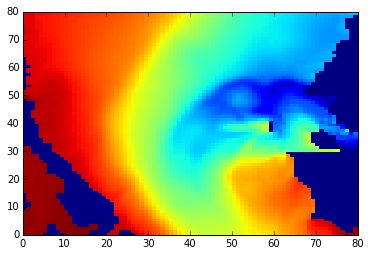

In [21]:
plt.pcolormesh(newvars['vosaline'][10,0,:,:])

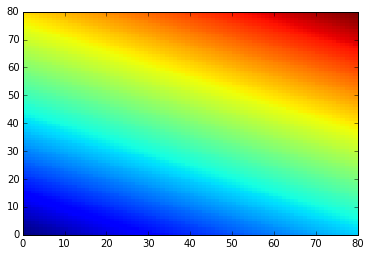

In [22]:

plt.pcolormesh(newvars['nav_lat'][:])

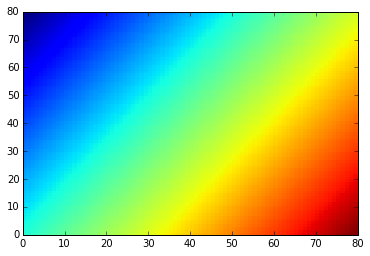

In [23]:
plt.pcolormesh(newvars['nav_lon'][:])

In [24]:
new.close()

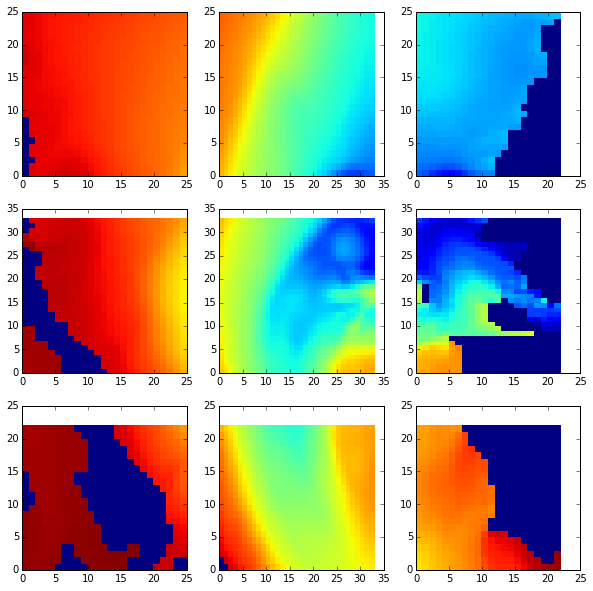

In [25]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
for ax, name in zip(axs.flatten(), filenames[::-1,:].flatten()):
    f=nc.Dataset(name)
    var = f.variables['vosaline'][10,0,:,:]
    ax.pcolormesh(var,vmin=0,vmax=30)

Improvements

Could attempt to copy over some of the metadeta...